In [2]:
import pandas as pd
import numpy as np

# Plotting and correlation
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
from scipy import stats

# Model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor

import warnings
warnings.filterwarnings('ignore')

Use hourly demand to predict hourly emissions

**Load data**

In [87]:
# CA hourly CO2 emissions and demand

df = pd.read_csv('data/hourly_emissions_demand.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)

print(f"shape: {df.shape}")
df.head()

shape: (4824, 3)


,date,demand,emissions
0,20221127T23Z,23637,84405
1,20221127T22Z,23599,87295
2,20221127T21Z,23323,88500
3,20221127T20Z,23718,88878
4,20221127T19Z,25038,90162


In [88]:
df.describe()

,demand,emissions
count,4824.000000,4824.000000
mean,33422.704602,84412.615672
std,6944.808812,30746.209923
min,20448.000000,230.000000
25%,28263.000000,65826.750000
50%,31794.000000,85747.000000
75%,37262.500000,102000.750000
max,63622.000000,208189.000000


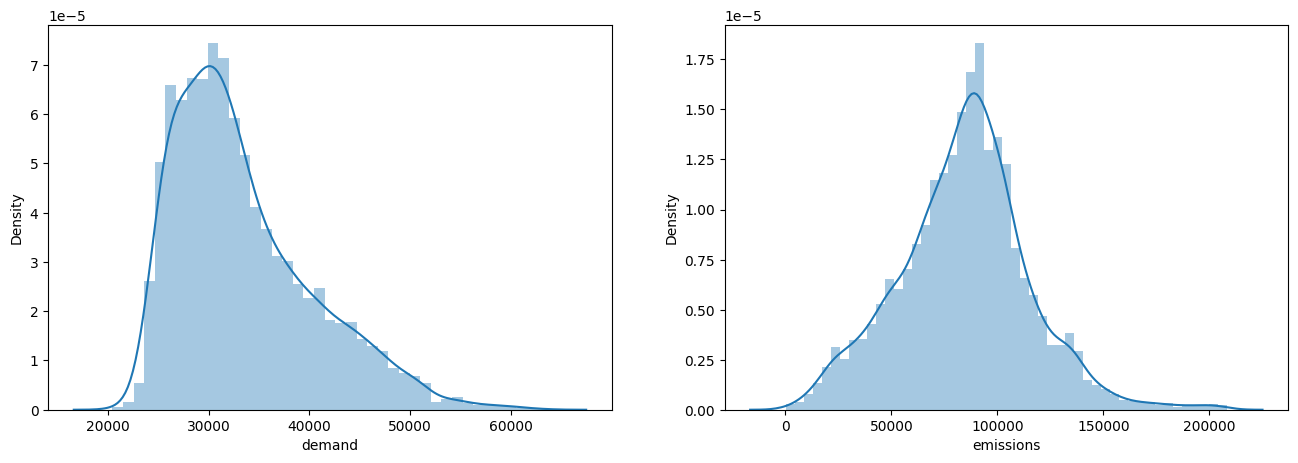

In [89]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.distplot(df['demand'])
plt.subplot(1,2,2)
sns.distplot(df['emissions'])
plt.show()

**Correlation**

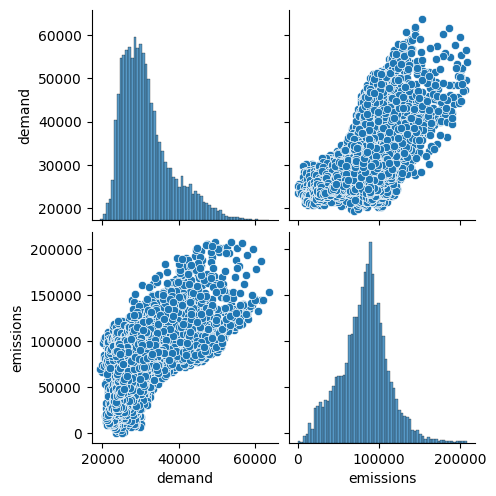

In [81]:
ed = df[['demand','emissions']]

sns.pairplot(ed, kind="scatter")
plt.show()

In [90]:
corrcoef = np.corrcoef(df['demand'], df['emissions'])[0,1]
print(f'Correlation coefficient: {corrcoef}')

p_value = linregress(df['demand'], df['emissions']).pvalue
print(f'p-value: {p_value}')

Correlation coefficient: 0.645216677738222
p-value: 0.0


**Linear regression**

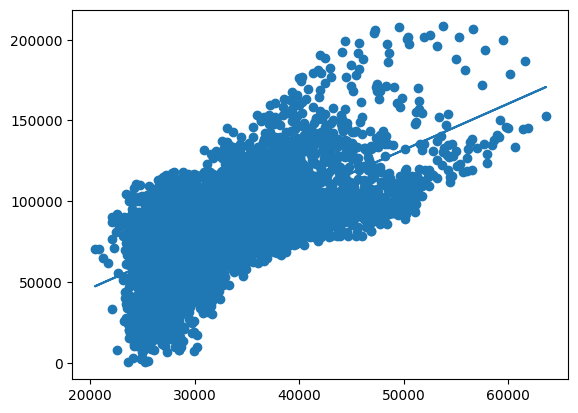

Correlation coefficient: 0.6452166777382222


In [91]:
X = df["demand"]
y = df["emissions"]

slope, intercept, r, p, std_err = stats.linregress(X, y)

def lin_func(X):
  return slope * X + intercept

linreg_model = list(map(lin_func, X))

plt.scatter(X, y)
plt.plot(X, linreg_model)
plt.show()

print(f'Correlation coefficient: {r}')

**Polynomial regression**

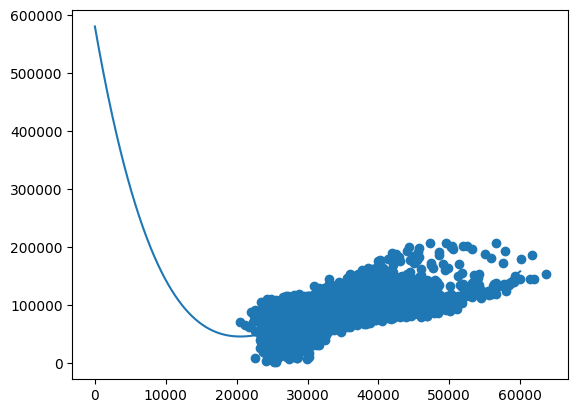

Training data score: 0.44608628214642
Testing data score: 0.4560687923491159


In [92]:
X = df["demand"]
y = df["emissions"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

poly_model = np.poly1d(np.polyfit(X_train, y_train, 4))

poly_line = np.linspace(0, 60000, 1000)

plt.scatter(X_train, y_train)
plt.plot(poly_line, poly_model(poly_line))
plt.show()

print(f'Training data score: {r2_score(y_train, poly_model(X_train))}')
print(f'Testing data score: {r2_score(y_test, poly_model(X_test))}')

**Logistic regression**

In [32]:
X = df.drop(columns=["date","emissions"])
y = df["emissions"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

log_reg = LogisticRegression()
log_reg.fit(X_train,y_train)

print(f'Testing data score: {log_reg.score(X_train, y_train)}')
print(f'Testing data score: {log_reg.score(X_test, y_test)}')

Testing data score: 0.001105583195135434
Testing data score: 0.0


**Random forest**

In [93]:
# Random forest regressor

X = df.drop(columns=["date","emissions"])
y = df["emissions"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

distribution = {
        'n_estimators': [2,5,50,100,200],
        'max_features': ['auto', 'sqrt','log2'],
        'min_samples_split': [1,3,5,8,10,15,20],
       }

random_forest = RandomForestRegressor()
rscv = RandomizedSearchCV(estimator = random_forest, param_distributions = distribution, n_iter = 10)
rscv.fit(X_train,  y_train)

print(f'Best params: {rscv.best_params_}')
print(f'Training data score: {rscv.score(X_train,  y_train)}')
print(f'Testing data score: {rscv.score(X_test, y_test)}')


Best params: {'n_estimators': 50, 'min_samples_split': 20, 'max_features': 'log2'}
Training data score: 0.6268867180348938
Testing data score: 0.4014338623814212


In [97]:
# Gradient boosting regressor

X = df.drop(columns=['date', 'emissions'])
y = df["emissions"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

gradient_boosting = GradientBoostingRegressor()

distribution = {
          'learning_rate' : [0.5,10,50,80],  
          'min_samples_split': [3,5,8,10,15,20,30],
          'max_depth': [5,8,10,12,18],
          #'n_estimators': [2,5,10,20,50,100,200,300],
          'max_features': ['sqrt','log2','auto'],
        }

rscv = RandomizedSearchCV(estimator = gradient_boosting, param_distributions = distribution, n_iter = 10)                
rscv.fit(X_train, y_train)

print(f'Best params: {rscv.best_params_}')
print(f'Training data score: {rscv.score(X_train,  y_train)}')
print(f'Testing data score: {rscv.score(X_test, y_test)}')


Best params: {'min_samples_split': 20, 'max_features': 'auto', 'max_depth': 10, 'learning_rate': 0.5}
Training data score: 0.8211450868560051
Testing data score: 0.2583433640931805


In [107]:
rscv.predict([[23637]])

array([83421.06656244])